# Numerical experiments

Dataset: [International Stroke Trial database (version 2)](https://datashare.ed.ac.uk/handle/10283/124)

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
from collections import Counter
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
import pandas as pd
from typing import List, Tuple, Protocol, Callable
import queue
from dataclasses import dataclass
import scipy
from scipy.special import digamma
from scipy.special import gamma
from collections import defaultdict
import pprint
import os
import pickle
import csv
from dataclasses import dataclass
import math
from pprint import pprint

## Data of interest

* tagert group: eldery (age > 65)
* control: no aspirin
* treatment: aspirin
* study: short-term (14 days)

In [3]:
ist = pd.read_csv('IST_corrected.csv',encoding='unicode_escape',low_memory=False)
display(ist.head(5))
ist.shape

,HOSPNUM,RDELAY,RCONSC,SEX,AGE,RSLEEP,RATRIAL,RCT,RVISINF,RHEP24,...,DEAD8,H14,ISC14,NK14,STRK14,HTI14,PE14,DVT14,TRAN14,NCB14
0,1,17,D,M,69,Y,NaN,Y,Y,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1,10,F,M,76,Y,NaN,Y,N,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1,43,F,F,71,N,NaN,Y,N,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1,6,F,M,81,N,NaN,N,N,NaN,...,0,0,0,0,0,0,0,0,0,0
4,4,20,F,M,78,N,NaN,N,N,NaN,...,0,0,0,0,0,0,0,0,0,0


(19435, 112)

In [4]:
ischaemic = ist[ist["DDIAGISC"] == "Y"]

In [5]:
# 1-Initial stroke/2-Recurrent stroke (ischaemic or unknown)/3-Recurrent stroke (haemorrhagic)/4-Pneumonia/5-Coronary heart disease/6-Pulmonary embolism/7-Other vascular or unknown/8-Non-vascular/0-unknown
# NaN must be not dead
def stroke_stats(df, limit = 20000):
    def get(group):
        total = group.shape[0]
        alive = group[(group["DDEADC"].isna())].shape[0]
        return total, alive, alive / total

    control = get(df[(df['RXASP'] == 'N')].head(limit))
    aspirin = get(df[(df['RXASP'] == 'Y')].head(limit))
    print(f"control: {control}")
    print(f"aspirin: {aspirin}")
    print(f"improvement: {100 * (aspirin[2] - control[2])/control[2]}%")
    

In [8]:
stroke_stats(ischaemic[(ischaemic["AGE"] > 65)], limit = 6334)

control: (6334, 5498, 0.8680138932743922)
aspirin: (6334, 5584, 0.8815914114303758)
improvement: 1.5642051655147378%


### Lifetime remaining days

In [9]:
df = ischaemic[(ischaemic["AGE"] > 65)]
pprint(df[(df["DDEADC"].notna())]["DDEADD"].value_counts().to_dict())

{0.0: 30,
 1.0: 136,
 2.0: 113,
 3.0: 130,
 4.0: 80,
 5.0: 102,
 6.0: 105,
 7.0: 90,
 8.0: 76,
 9.0: 74,
 10.0: 64,
 11.0: 49,
 12.0: 58,
 13.0: 38,
 14.0: 35,
 15.0: 31,
 16.0: 26,
 17.0: 23,
 18.0: 14,
 19.0: 12,
 20.0: 15,
 21.0: 11,
 22.0: 7,
 23.0: 8,
 24.0: 8,
 25.0: 11,
 26.0: 7,
 27.0: 3,
 28.0: 5,
 29.0: 2,
 30.0: 6,
 31.0: 4,
 32.0: 8,
 33.0: 5,
 34.0: 3,
 35.0: 3,
 36.0: 8,
 37.0: 3,
 38.0: 1,
 39.0: 2,
 40.0: 2,
 41.0: 4,
 42.0: 1,
 43.0: 1,
 44.0: 7,
 45.0: 2,
 46.0: 2,
 47.0: 2,
 49.0: 1,
 50.0: 1,
 53.0: 2,
 55.0: 1,
 56.0: 2,
 57.0: 1,
 58.0: 2,
 62.0: 1,
 63.0: 1,
 66.0: 1,
 71.0: 1,
 73.0: 3,
 74.0: 2,
 85.0: 1,
 117.0: 1,
 121.0: 1,
 149.0: 1}


(array([0.09039574, 0.06803981, 0.06706781, 0.05378385, 0.04471187,
        0.0346679 , 0.02365193, 0.02591993, 0.00842398, 0.00842398,
        0.00485999, 0.00615598, 0.00323999, 0.00226799, 0.00323999,
        0.00518399, 0.00356399, 0.001296  , 0.001296  , 0.00162   ,
        0.00259199, 0.001296  , 0.000648  , 0.000648  , 0.000648  ,
        0.000324  , 0.000972  , 0.000648  , 0.        , 0.000648  ,
        0.        , 0.000324  , 0.        , 0.000324  , 0.00162   ,
        0.        , 0.        , 0.        , 0.        , 0.000324  ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.000324  ,
        0.        , 0.000324  , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.000324  ]),
 array([  0.        ,   2.12857143,   4.257142

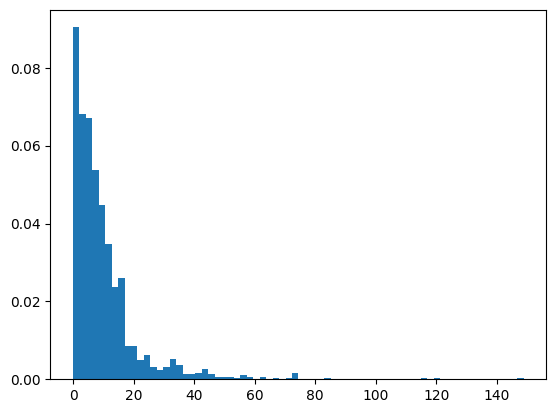

In [10]:
remaining_days = [int(d) for d in df[(df["DDEADC"].notna()) & (df["DDEADD"].notna())]["DDEADD"]]
plt.hist(remaining_days, bins = 70, density=True)

In [13]:
REMAINING_DAYS = remaining_days
np.random.choice(REMAINING_DAYS)

9

### Experiment (randomization) period

In [14]:
df = ischaemic[(ischaemic["AGE"] > 65)]

In [15]:
dates = [(d.split('-')[1], d.split('-')[0]) for d in list(df["RDATE"])]
pprint(sorted(dates))

[('91', 'cze'),
 ..
 ('96', 'sty'),
 ('96', 'sty')]


In [16]:
Counter([d[0] for d in dates])

Counter({'91': 149, '92': 244, '93': 2213, '94': 3996, '95': 4360, '96': 1724})

In [17]:
RANDOMIZATION_PERIOD_IN_DAYS = 365*3

## Simulation

Settings:

1. **UCB** policy in the MAB model **with beta rewards**. Assumes an accurate and in-time estimation of reward (certainty of successful treatment).
2. **Uniform at Random** policy in the MAB model **with Bernoulli rewards**. Similates the randomized controlled trial.
3. **Thompson Sampling** policy in the MAB model **with Bernoulli rewards neglecting delays** (not-properly designed simulation).
4. **Thompson Sampling** policy in the MAB model **with Bernoulli rewards adapted to the delays** with the help of [Joulani et al.’s framework](https://proceedings.mlr.press/v28/joulani13.html).

In [18]:
# return a delay in time steps
def sample_14data_delay(num_patients: int, alive: bool) -> int:
    num_daily_patiants = int(num_patients/ RANDOMIZATION_PERIOD_IN_DAYS)
    if alive:
        return 14 * num_daily_patiants

    # + 1 as we have 0 value for the case when death reported on the same day
    days = np.random.choice(REMAINING_DAYS) + 1
    return days * num_daily_patiants

print(sample_14data_delay(num_patients=6334*2, alive=False))
print(sample_14data_delay(num_patients=6334*2, alive=True))
print(f"num_daily_patiants = {int(6334*2/ RANDOMIZATION_PERIOD_IN_DAYS)}")

121
154
num_daily_patiants = 11


In [19]:
class Environment(Protocol):
    num_actions: int
    means: np.ndarray
    name: str

    def draw(self, t: int, action: int) -> float:
        ...

class BetaBandit(Environment):
    def __init__(self, alphas: np.ndarray, betas: np.ndarray, horizon: int):
        self.name = "Beta"
        self.alphas = alphas
        self.betas = betas
        self.num_actions = len(alphas)
        self.means = [alphas[i] / (alphas[i] + betas[i]) for i in range(self.num_actions)]

    def draw(self, t: int, action: int) -> float:
        return np.random.beta(a=self.alphas[action], b=self.betas[action])

class BernoulliBandit(Environment):
    def __init__(self, means: np.ndarray, horizon: int):
        self.name = "Bernoulli"
        self.means = means
        self.num_actions = len(means)

    def draw(self, t: int, action: int) -> float:
        return np.random.binomial(n=1, p=self.means[action])

class Policy(Protocol):
    actions_count: np.ndarray
    name: str
    
    def select(self, t: int) -> int:
        ...

    def update(self, t: int, action: int, reward: float):
        ...
    
class UCB(Policy):
    def __init__(self, num_actions: int, horizon: int):
        self.name = "UCB"
        self.num_actions = num_actions
        self.horizon = horizon
        self.cumulative_rewards = np.zeros(num_actions, dtype=np.float32)
        self.actions_count = np.zeros(num_actions, dtype=np.int32)

    def select(self, t: int) -> int:
        if t < self.num_actions:
            return t

        actions = np.arange(self.num_actions)
        indexes = np.array([self.index(t=t, action=i) for i in actions])
        idx = np.where(indexes == np.max(indexes))
        best_actions = actions[idx]
        return np.random.choice(best_actions)

    def update(self, t: int, action: int, reward: float):
        self.cumulative_rewards[action] += reward
        self.actions_count[action] += 1
        return

    def index(self, t, action) -> float:
        # p = 1/n^2, alpha = 1/4
        mean = self.cumulative_rewards[action] / self.actions_count[action]
        confidence_radius = math.sqrt(math.log(self.horizon**2) / (4 * self.actions_count[action]))
        return mean + confidence_radius
    
class ThompsonSampling(Policy):
    def __init__(self, num_actions: int, horizon: int):
        self.name = "ThompsonSampling"
        self.num_actions = num_actions
        self.horizon = horizon
        self.alpha_0 = 1.0
        self.beta_0 = 1.0
        self.alphas = np.zeros(num_actions, dtype=float)
        self.betas = np.zeros(num_actions, dtype=float)
        self.actions_count = np.zeros(num_actions, dtype=np.int32)

    def select(self, t: int) -> int:
        samples = np.zeros(self.num_actions, dtype=float)
        for i in range(self.num_actions):
            alpha = self.alphas[i] + self.alpha_0
            beta = self.betas[i] + self.beta_0
            samples[i] = np.random.beta(alpha, beta)
        return int(np.argmax(samples))

    def update(self, t: int, action: int, reward: float):
        self.alphas[action] = self.alphas[action] + reward
        self.betas[action] = self.betas[action] + (1.0 - reward)
        self.actions_count[action] += 1

class UniformRandom(Policy):
    def __init__(self, num_actions: int):
        self.name = "UniformRandom"
        self.num_actions = num_actions
        self.actions_count = np.zeros(num_actions, dtype=np.int32)

    def select(self, t: int) -> int:
        return np.random.choice(self.num_actions)

    def update(self, t: int, action: int, reward: float):
        self.actions_count[action] += 1
        return

In [20]:
class Experiment:
    def __init__(self, horizon: int):    
        # revealed rewards by environment not taking into account delays
        self.rewards = np.zeros(horizon, dtype=np.float32)
        # delay per time step
        self.delays = np.zeros(horizon, dtype=np.int32)

def run_experiment(horizon: int, environment: Environment, policy: Policy,
                   sample_delay: Callable[[int, bool], int]):
    experiment = Experiment(horizon=horizon)
    num_actions = environment.num_actions
    # FIFO queue per action with realized rewards
    queues: List[queue.Queue] = [queue.Queue() for _ in range(num_actions)]
    # delayed rewards to be realized at time step: Tuple[action, reward]
    future_rewards: List[List[Tuple[int, float]]] = [[] for _ in range(horizon)]

    # internal policy's time step to emulate sequential decision making with no delays
    policy_t = 0
    action = policy.select(policy_t)

    for t in range(horizon):
        while not queues[action].empty():
            reward = queues[action].get()
            policy.update(t=policy_t, action=action, reward=reward)
            policy_t += 1
            action = policy.select(policy_t)

        reward = environment.draw(t=t, action=action)
        experiment.rewards[t] = reward

        experiment.delays[t] = sample_delay(num_patients=horizon, alive=bool(reward))
        if t + experiment.delays[t] < horizon:
            future_rewards[t + experiment.delays[t]].append((action, reward))

        # realize rewards for the current time step if any
        for a, r in future_rewards[t]:
            queues[a].put(r)

        # trigger update again for the case of no delay on this time step
        while not queues[action].empty():
            reward = queues[action].get()
            policy.update(t=policy_t, action=action, reward=reward)
            policy_t += 1
            action = policy.select(policy_t)

    return experiment

In [21]:
# control: (6334, 5498, 0.8680138932743922)
# aspirin: (6334, 5584, 0.8815914114303758)

num_experiments = 2000
horizon = 6334*2
num_actions = 2

true_means = [0.8680138932743922, 0.8815914114303758]
beta_alphas = np.array([5498, 5584])
beta_betas = np.array([6334 - alpha for alpha in beta_alphas])

def build_policies():
    return [
        UCB(num_actions=num_actions, horizon=horizon),
        UniformRandom(num_actions=num_actions),
        ThompsonSampling(num_actions=num_actions, horizon=horizon),
        ThompsonSampling(num_actions=num_actions, horizon=horizon),
    ]
def build_envs():
    return [
        BetaBandit(alphas=beta_alphas, betas=beta_betas, horizon=horizon),
        BernoulliBandit(means=true_means, horizon=horizon),
        BernoulliBandit(means=true_means, horizon=horizon),
        BernoulliBandit(means=true_means, horizon=horizon)
    ]
num_policies = len(build_policies())
assert num_policies == len(build_envs())

names = [
    "Beta - UCB",
    "Bernoulli - Uniform Random",
    "Bernoulli - ThompsonSampling",
    "Bernoulli - ThompsonSampling [with delays]"
]
assert num_policies == len(names)

optimal_means = [np.max(build_envs()[j].means) for j in range(num_policies)]
print(f"optimal means: {optimal_means}")

rewards = np.full((num_experiments, num_policies, horizon), fill_value=-1, dtype=np.float32)
delays = np.zeros((num_experiments, num_policies, horizon), dtype=np.int32)
actions_count = np.zeros((num_experiments, num_policies, num_actions), dtype=np.int32)

for exp_id in range(num_experiments):    
    envs = build_envs()
    policies = build_policies()

    delay_sampler = [None] * num_policies
    for j in range(num_policies):
        if "[with delays]" in names[j]:
            delay_sampler[j] = sample_14data_delay
        else:
            delay_sampler[j] = lambda num_patients, alive : 0

    runs = [
        run_experiment(horizon=horizon, environment=envs[j], policy=policies[j], sample_delay=delay_sampler[j])
        for j in range(num_policies)
    ]

    for j in range(num_policies):
        rewards[exp_id, j] = runs[j].rewards
        actions_count[exp_id, j] = policies[j].actions_count
        delays[exp_id, j] = runs[j].delays
    print(f"{exp_id}", end='\r')

total_regrets = np.zeros((num_experiments, num_policies), dtype=np.float32)
for exp_id in range(num_experiments):
    for j in range(num_policies):
        total_regrets[exp_id, j] = horizon * optimal_means[j] - np.sum(rewards[exp_id, j, :])

avg_delay = np.zeros((num_experiments, num_policies), dtype=np.float32)
for exp_id in range(num_experiments):
    for j in range(num_policies):
        avg_delay[exp_id, j] = np.mean(delays[exp_id, j, :])
        
output = defaultdict(list)
for j in range(num_policies):
    output["name"].append(names[j])
    output["regret (mean)"].append(np.mean(total_regrets[:, j]))
    output["std"].append(np.std(total_regrets[:, j]))
    output["min"].append(np.min(total_regrets[:, j]))
    output["max"].append(np.max(total_regrets[:, j]))
    output["delay (mean)"].append(np.mean(avg_delay[:, j]))
pd.DataFrame(data=output)

optimal means: [0.8815914114303758, 0.8815914114303758, 0.8815914114303758, 0.8815914114303758]


,name,regret (mean),std,min,max,delay (mean)
0,Beta - UCB,48.517677,0.495571,46.97168,50.060547,0.000000
1,Bernoulli - Uniform Random,85.459999,36.365772,-22.00000,215.000000,0.000000
2,Bernoulli - ThompsonSampling,31.055000,48.871395,-114.00000,280.000000,0.000000
3,Bernoulli - ThompsonSampling [with delays],74.071999,90.893860,-126.00000,280.000000,149.923126


In [24]:
def draw_acc_regret():
    regrets = np.zeros((num_policies, num_experiments, horizon), dtype=np.float32)

    for exp_id in range(num_experiments):
        for j in range(num_policies):
            regrets[j, exp_id] = np.full(horizon, fill_value=optimal_means[j], dtype=np.float32) - rewards[exp_id, j]
            for t in range(1, horizon):
                regrets[j, exp_id, t] += regrets[j, exp_id][t-1]
        print(f"{exp_id}", end='\r')

    for j in range(num_policies):
        _regrets = np.mean(regrets[j], axis=0)
        plt.plot(range(0, horizon), _regrets, label=f"{names[j]}")
    plt.legend()
    plt.show()

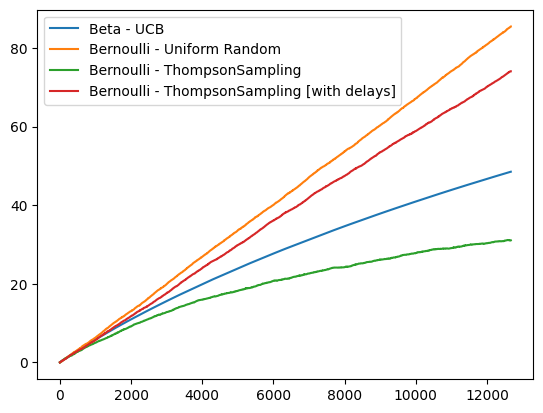

In [25]:
draw_acc_regret()